# 1. Clean and Explore
This notebook contains the process used to import, examine, and clean the dataset containing COVID hospital cases by county in the contiguous USA.

**Goal: Plot the hospital cases on a map of the contiguous USA and size these points based on number of patients.**

# 1.0.1 Import Packages

In [1]:
import numpy as np #linear algebra
import pandas as pd #data processing, CSV file I/O
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Import libraries for reading geographic data
import geopandas as gpd
from shapely.geometry import Point, shape
import io
import addfips

%matplotlib inline

/Users/tiffanyflor/.pyenv/versions/3.8.2/lib/python3.8/site-packages/pandas/compat/__init__.py:117: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [2]:
os.getcwd()

'/Users/tiffanyflor/Dropbox/MyProjects/usacovidhosp/notebooks'

In [3]:
# List files in the raw data directory

for dirname, _, filenames in os.walk('../data/raw/'):
    for filename in filenames:
        print(filename)

tl_2019_us_state.shp
tl_2019_us_state.shx
tl_2017_us_county.cpg
tl_2017_us_county.shp
Merged_Final.csv
tl_2017_us_county.shx
.gitkeep
tl_2017_us_county.dbf
tl_2019_us_state.dbf
tl_2019_us_state.prj
tl_2017_us_county.prj
co-est2019-alldata.csv


# 1.1.1 Import and Examine COVID Hospital Data
Import dataset as a pandas DataFrame. Examine metadata and univariate descriptive statistics.
<br><br>Date includes:
- County Name
- Facility_Name
- Full_Address
- State
- Total (Covid patients)
- latitudes
- longitudes

In [4]:
# Merged_Final.csv --> contains USA hospitals with COVID by county
# Put into dataframe
hosp = pd.read_csv('../data/raw/Merged_Final.csv')

In [5]:
# View data
hosp.head()

,County Name,Facility_Name,Full_Address,State,Total,latitudes,longitudes
0,HOUSTON,SOUTHEAST ALABAMA MEDICAL CENTER,"1108 ROSS CLARK CIRCLE,DOTHAN,HOUSTON,AL",AL,2427,31.215827,-85.363433
1,MARSHALL,MARSHALL MEDICAL CENTERS,"2505 U S HIGHWAY 431 NORTH,BOAZ,MARSHALL,AL",AL,5104,34.601233,-87.123343
2,LAUDERDALE,NORTH ALABAMA MEDICAL CENTER,"1701 VETERANS DRIVE,FLORENCE,LAUDERDALE,AL",AL,2120,34.805043,-87.650814
3,JEFFERSON,ST. VINCENT'S EAST,"50 MEDICAL PARK EAST DRIVE,BIRMINGHAM,JEFFERSO...",AL,26142,33.564772,-86.760155
4,SHELBY,SHELBY BAPTIST MEDICAL CENTER,"1000 FIRST STREET NORTH,ALABASTER,SHELBY,AL",AL,20720,33.075378,-86.519100


In [6]:
# Get rows and columns
hosp.shape

(4478, 7)

In [7]:
# List data types and counts
hosp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4478 entries, 0 to 4477
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   County Name    4478 non-null   object 
 1   Facility_Name  4478 non-null   object 
 2   Full_Address   4478 non-null   object 
 3   State          4478 non-null   object 
 4   Total          4478 non-null   int64  
 5   latitudes      4478 non-null   float64
 6   longitudes     4478 non-null   float64
dtypes: float64(2), int64(1), object(4)
memory usage: 245.0+ KB


In [8]:
# Summary statistics for numerical columns
hosp.describe(include=[np.number])

,Total,latitudes,longitudes
count,4478.000000,4478.000000,4478.000000
mean,13635.779812,37.942630,-93.095641
std,27010.816470,5.383805,14.995810
min,0.000000,18.372500,-159.671259
25%,497.000000,34.001714,-99.310467
50%,3581.000000,38.773624,-90.291356
75%,14835.000000,41.682943,-82.382111
max,159045.000000,58.329259,-66.046000


In [9]:
# Summary statistics for object and categorical columns
hosp.describe(include=[np.object, pd.Categorical])

,County Name,Facility_Name,Full_Address,State
count,4478,4478,4478,4478
unique,1273,4341,4476,51
top,LOS ANGELES,MEMORIAL HOSPITAL,"101 CIRCLE DRIVE,HILLSBORO,HILL,TX",TX
freq,90,12,2,407


## 1.1.2 Clean Hospital Data
Drop unnecessary rows and remove duplicates. Reset index for a clean dataframe.

In [10]:
# Check out the number of states listed
hosp['State'].nunique()

51

In [11]:
# Notice it includes Puerto Rico
hosp['State'].unique()

array(['AL', 'AK', 'AZ', 'AR', 'CA', 'CO', 'CT', 'DE', 'FL', 'GA', 'HI',
       'ID', 'IL', 'IN', 'IA', 'KS', 'KY', 'LA', 'ME', 'MD', 'MA', 'MI',
       'MN', 'MS', 'MO', 'MT', 'NE', 'NV', 'NH', 'NJ', 'NM', 'NY', 'NC',
       'ND', 'OH', 'OK', 'OR', 'PA', 'PR', 'RI', 'SC', 'SD', 'TN', 'TX',
       'UT', 'VT', 'VA', 'WA', 'WV', 'WI', 'WY'], dtype=object)

In [12]:
# Since we are only concerned with the 50 US states, we'll drop rows containing PR
hosp = hosp[hosp.State != 'PR']
hosp.shape

(4460, 7)

In [13]:
# Check for duplicate hospitals
hosp['Full_Address'].value_counts()

47 SOUTH FOURTH ST,ROLLING FORK,SHARKEY,MS    2
101 CIRCLE DRIVE,HILLSBORO,HILL,TX            2
150 MEMORIAL DRIVE,KINGWOOD,PRESTON,WV        1
101 WEST 8TH AVENUE,SPOKANE,SPOKANE,WA        1
234 EAST 149TH STREET,BRONX,BRONX,NY          1
                                             ..
1 MEDICAL CENTER DRIVE,LEBANON,GRAFTON,NH     1
603 SOUTH CHESTNUT,ELLENSBURG,KITTITAS,WA     1
ONE HOSPITAL DRIVE,COLUMBIA,BOONE,MO          1
77 N AIRLITE STREET,ELGIN,KANE,IL             1
6000 HOSPITAL DR,HANNIBAL,MARION,MO           1
Name: Full_Address, Length: 4458, dtype: int64

In [14]:
# Examine hospitals with more than one listing
hosp[hosp['Full_Address'] == '47 SOUTH FOURTH ST,ROLLING FORK,SHARKEY,MS']

,County Name,Facility_Name,Full_Address,State,Total,latitudes,longitudes
2158,SHARKEY,SHARKEY ISSAQUENA COMMUNITY HOSPITAL,"47 SOUTH FOURTH ST,ROLLING FORK,SHARKEY,MS",MS,65,34.004727,-90.070306
2212,SHARKEY,SHARKEY ISSAQUENA COMMUNITY HOSPITAL,"47 SOUTH FOURTH ST,ROLLING FORK,SHARKEY,MS",MS,65,34.004727,-90.070306


In [15]:
hosp[hosp['Full_Address'] == '101 CIRCLE DRIVE,HILLSBORO,HILL,TX']

,County Name,Facility_Name,Full_Address,State,Total,latitudes,longitudes
3725,HILL,HILL REGIONAL HOSPITAL,"101 CIRCLE DRIVE,HILLSBORO,HILL,TX",TX,239,31.269893,-98.943568
3947,HILL,HILL REGIONAL HOSPITAL,"101 CIRCLE DRIVE,HILLSBORO,HILL,TX",TX,239,31.269893,-98.943568


In [16]:
# Review areas around index to determine if there is an obvious order to hospital input
hosp.iloc[2155:2163]

,County Name,Facility_Name,Full_Address,State,Total,latitudes,longitudes
2155,HINDS,MERIT HEALTH CENTRAL,"1850 CHADWICK DR,JACKSON,HINDS,MS",MS,3691,32.287775,-90.254940
2156,WAYNE,WAYNE GENERAL HOSPITAL,"950 MATTHEW DR,WAYNESBORO,WAYNE,MS",MS,29753,31.673138,-88.634152
2157,FORREST,FORREST GENERAL HOSPITAL,"6051 US HIGHWAY 49,HATTIESBURG,FORREST,MS",MS,1197,33.079453,-89.858575
2158,SHARKEY,SHARKEY ISSAQUENA COMMUNITY HOSPITAL,"47 SOUTH FOURTH ST,ROLLING FORK,SHARKEY,MS",MS,65,34.004727,-90.070306
2159,LAUDERDALE,ANDERSON REGIONAL MEDICAL CENTER SOUTH CAMPUS,"1102 CONSTITUTION AVENUE,MERIDIAN,LAUDERDALE,MS",MS,2120,31.686577,-88.652958
2160,WASHINGTON,DELTA REGIONAL MEDICAL CENTER,"1400 E UNION ST,GREENVILLE,WASHINGTON,MS",MS,17929,33.410527,-91.035356
2161,ADAMS,MERIT HEALTH NATCHEZ,"52 SERGEANT PRENTISS DRIVE,NATCHEZ,ADAMS,MS",MS,7059,31.867069,-90.443150
2162,MARION,MARION GENERAL HOSPITAL,"1560 SUMRALL RD,COLUMBIA,MARION,MS",MS,22462,31.255953,-89.805607


In [17]:
# No obvious pattern found
# Drop 2nd occurence of each duplicate
hosp.drop([2212,3947], inplace=True)

In [18]:
# Check rows have been dropped
hosp.loc[2211:2213]

,County Name,Facility_Name,Full_Address,State,Total,latitudes,longitudes
2211,TIPPAH,TIPPAH COUNTY HOSPITAL,"1005 CITY AVE NORTH,RIPLEY,TIPPAH,MS",MS,193,34.739039,-88.950607
2213,RANKIN,BRENTWOOD BEHAVIORAL HEALTHCARE OF MS,"3531 EAST LAKELAND DRIVE,FLOWOOD,RANKIN,MS",MS,1459,32.357990,-90.011870


In [19]:
hosp.loc[3945:3948]
# Notice that the index and iloc do not match anymore so we had to use loc
# and now have to reset index

,County Name,Facility_Name,Full_Address,State,Total,latitudes,longitudes
3945,HAMILTON,HAMILTON GENERAL HOSPITAL,"400 N BROWN, BUILDING 1,HAMILTON,HAMILTON,TX",TX,15125,31.703875,-98.113448
3946,HOUSTON,CROCKETT MEDICAL CENTER,"1100 E LOOP 304,CROCKETT,HOUSTON,TX",TX,2427,31.322152,-95.437114
3948,TARRANT,COOK CHILDRENS MEDICAL CENTER,"801 SEVENTH AVENUE,FORT WORTH,TARRANT,TX",TX,21617,30.851827,-95.187186


In [20]:
# Reset index
hosp.reset_index(drop=True, inplace=True)

# Check index has been reset
hosp.iloc[3945:3948]

,County Name,Facility_Name,Full_Address,State,Total,latitudes,longitudes
3945,KERR,KERRVILLE STATE HOSP,"721 THOMPSON DR,KERRVILLE,KERR,TX",TX,255,30.045887,-99.157744
3946,WICHITA,RED RIVER HOSPITAL,"1505 8TH ST,WICHITA FALLS,WICHITA,TX",TX,709,33.906316,-98.501335
3947,HARRIS,WEST OAKS HOSPITAL,"6500 HORNWOOD,HOUSTON,HARRIS,TX",TX,56280,29.708962,-95.496980


## 1.1.3 Add County and State FIPS
This allows for common identifiers between dataframes and geodataframes, eventually allowing merges when necessary.

In [21]:
hosp['STATEFP'] = ""
hosp['COUNTYFP'] = ""

af = addfips.AddFIPS()
for i in range(len(hosp)):
    hosp['STATEFP'][i] = af.get_state_fips(hosp['State'][i])
    hosp['COUNTYFP'][i] = af.get_county_fips(hosp['County Name'][i], state=hosp['State'][i])

<ipython-input-21-38e9f471ea41>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hosp['STATEFP'][i] = af.get_state_fips(hosp['State'][i])
<ipython-input-21-38e9f471ea41>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hosp['COUNTYFP'][i] = af.get_county_fips(hosp['County Name'][i], state=hosp['State'][i])


In [22]:
# Check that all rows have state and county fp entered
hosp[hosp.COUNTYFP.isnull()]

,County Name,Facility_Name,Full_Address,State,Total,latitudes,longitudes,STATEFP,COUNTYFP
1143,LA SALLE,OTTAWA REGIONAL HOSPITAL DBA OSF SAINT ELIZABE...,"1100 EAST NORRIS DRIVE,OTTAWA,LA SALLE,IL",IL,311,41.343242,-88.854734,17,None
1171,LA SALLE,ILLINOIS VALLEY COMMUNITY HOSPITAL,"925 WEST ST,PERU,LA SALLE,IL",IL,311,41.333870,-89.105948,17,None
1190,LA SALLE,OSF SAINT PAUL MEDICAL CENTER,"1401 E 12TH STREET,MENDOTA,LA SALLE,IL",IL,311,41.134772,-88.931537,17,None
1697,LASALLE,LASALLE GENERAL HOSPITAL,"187 NINTH ST/HWY 84 WEST,JENA,LASALLE,LA",LA,343,29.975760,-91.947620,22,None
1718,LASALLE,HARDTNER MEDICAL CENTER,"1102 N PINE ROAD,OLLA,LASALLE,LA",LA,343,29.975760,-91.947620,22,None
3773,DE WITT,CUERO REGIONAL HOSPITAL,"2550 N ESPLANADE,CUERO,DE WITT,TX",TX,21,35.328255,-100.502868,48,None


In [23]:
# Look up FIPS for each county / state and manually enter
illinois = [1143, 1171, 1190]
for i in illinois:
    hosp['COUNTYFP'][i] = 17099

louisiana = [1697, 1718]
for l in louisiana:
    hosp['COUNTYFP'][l] = 22059
    
hosp['COUNTYFP'][3773] = 48123


<ipython-input-23-038d5cdeffa4>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hosp['COUNTYFP'][i] = 17099
<ipython-input-23-038d5cdeffa4>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hosp['COUNTYFP'][l] = 22059
<ipython-input-23-038d5cdeffa4>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hosp['COUNTYFP'][3773] = 48123


In [24]:
hosp.isnull().sum()

County Name      0
Facility_Name    0
Full_Address     0
State            0
Total            0
latitudes        0
longitudes       0
STATEFP          0
COUNTYFP         0
dtype: int64

## 1.1.3 Reduce Memory Usage of Hospital Data
Change data types of columns

In [25]:
# Inspect the data types of each column
hosp.dtypes

County Name       object
Facility_Name     object
Full_Address      object
State             object
Total              int64
latitudes        float64
longitudes       float64
STATEFP           object
COUNTYFP          object
dtype: object

In [26]:
# Find memory usage of each column
original_mem = hosp.memory_usage(deep=True)
original_mem

Index               128
County Name      286237
Facility_Name    381694
Full_Address     432295
State            263022
Total             35664
latitudes         35664
longitudes        35664
STATEFP          263022
COUNTYFP         276240
dtype: int64

In [27]:
# We know from our examination above that State only has 50 unique values
# It can be changed to a categorical variable
# Can anything else? Find the percentage of unique values in each category
hosp.select_dtypes(include=['object']).nunique()/hosp.select_dtypes(include=['object']).count()

County Name      0.285554
Facility_Name    0.969717
Full_Address     1.000000
State            0.011216
STATEFP          0.011216
COUNTYFP         0.465455
dtype: float64

In [28]:
# We see that County Name has about 29% unique values,
# Facility has 97%, Full_Address has 100%, and State has 1%
# The best candidates for categorical are the State and STATEFP columns
hosp['State'] = hosp['State'].astype('category')
hosp['STATEFP'] = hosp['STATEFP'].astype('category')

In [29]:
hosp['COUNTYFP'] = pd.to_numeric(hosp['COUNTYFP'])
hosp.dtypes

County Name        object
Facility_Name      object
Full_Address       object
State            category
Total               int64
latitudes         float64
longitudes        float64
STATEFP          category
COUNTYFP            int64
dtype: object

In [30]:
# compute new memory usage
new_mem = hosp.memory_usage(deep=True)
new_mem

Index               128
County Name      286237
Facility_Name    381694
Full_Address     432295
State              9968
Total             35664
latitudes         35664
longitudes        35664
STATEFP            9968
COUNTYFP          35664
dtype: int64

In [31]:
# Compare original with updated memory usage
new_mem/original_mem

Index            1.000000
County Name      1.000000
Facility_Name    1.000000
Full_Address     1.000000
State            0.037898
Total            1.000000
latitudes        1.000000
longitudes       1.000000
STATEFP          0.037898
COUNTYFP         0.129105
dtype: float64

State has shrunk to 3.8% of its original size.<br>
STATEFP has shrunk to 4% of its original size.<br>
COUNTYFP has shrunk to 13% of its original size.

## 1.1.4 Visualize Hospital Data Statistics

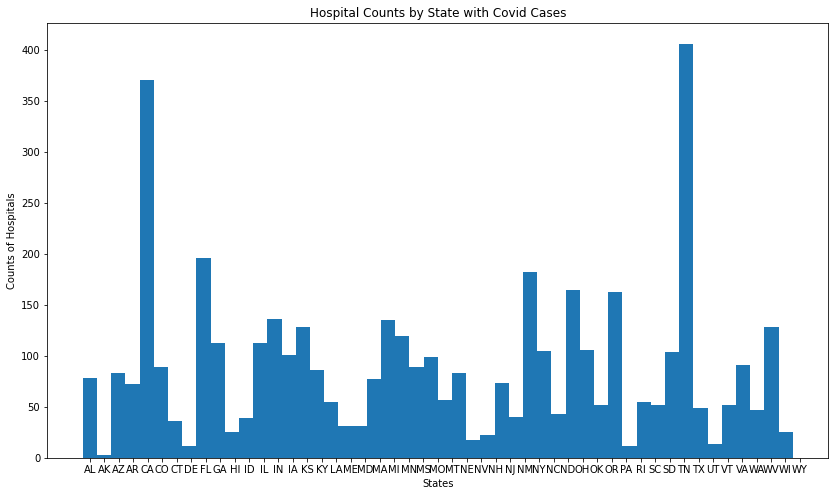

In [32]:
# Now that the dataframe is clean, let's vizualize the statistics to see if anything else needs to be done
# Histogram of Hospital Frequency
_ = plt.figure(figsize=(14,8))
_ = plt.hist(hosp['State'], bins=hosp['State'].nunique(), align='left')
_ = plt.xlabel('States')
_ = plt.ylabel('Counts of Hospitals')
_ = plt.title('Hospital Counts by State with Covid Cases')
plt.show()

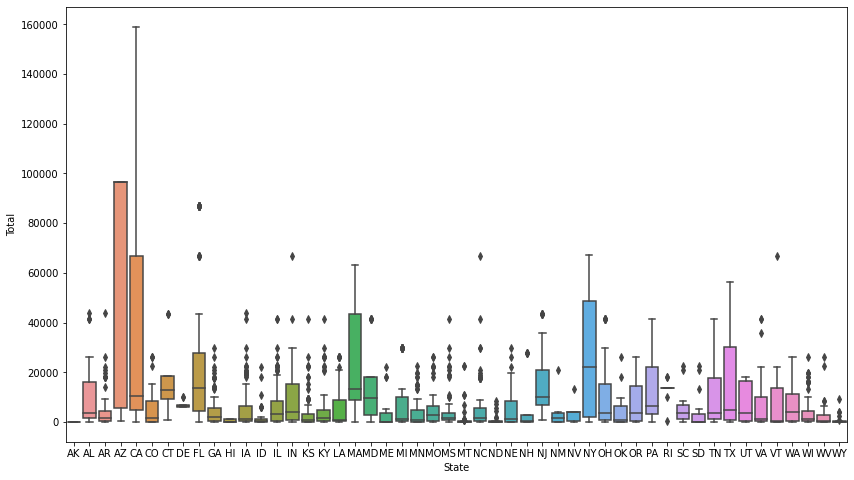

In [33]:
# Boxplot of hospital total cases
plt.figure(figsize=(14,8))
sns.boxplot(x=hosp['State'], y= hosp['Total'], data=hosp)
plt.show()

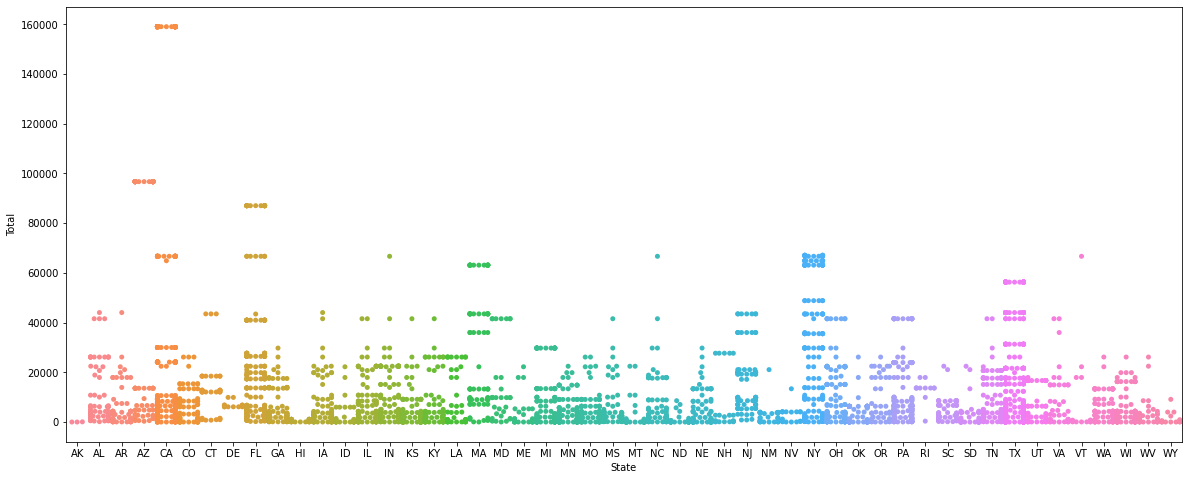

In [34]:
# Swarmplot to see how often values occur
plt.figure(figsize=(20,8))
sns.swarmplot(x=hosp['State'], y= hosp['Total'], data=hosp)
plt.show()

## 1.1.5 Convert Hospital DataFrame to GeoDataFrame for Plotting

In [95]:
# convert hosp dataframe into geodataframe to allow for plotting of hospitals in a later step
# geometry = [Point(xy) for xy in zip(hosp.longitudes, hosp.latitudes)]
gdf_hosp = gpd.GeoDataFrame(hosp, crs='EPSG:4326', geometry=gpd.points_from_xy(hosp.longitudes, hosp.latitudes))
gdf_hosp.head()

,County Name,Facility_Name,Full_Address,State,Total,latitudes,longitudes,STATEFP,COUNTYFP,geometry
0,HOUSTON,SOUTHEAST ALABAMA MEDICAL CENTER,"1108 ROSS CLARK CIRCLE,DOTHAN,HOUSTON,AL",AL,2427,31.215827,-85.363433,01,1069,POINT (-85.36343 31.21583)
1,MARSHALL,MARSHALL MEDICAL CENTERS,"2505 U S HIGHWAY 431 NORTH,BOAZ,MARSHALL,AL",AL,5104,34.601233,-87.123343,01,1095,POINT (-87.12334 34.60123)
2,LAUDERDALE,NORTH ALABAMA MEDICAL CENTER,"1701 VETERANS DRIVE,FLORENCE,LAUDERDALE,AL",AL,2120,34.805043,-87.650814,01,1077,POINT (-87.65081 34.80504)
3,JEFFERSON,ST. VINCENT'S EAST,"50 MEDICAL PARK EAST DRIVE,BIRMINGHAM,JEFFERSO...",AL,26142,33.564772,-86.760155,01,1073,POINT (-86.76016 33.56477)
4,SHELBY,SHELBY BAPTIST MEDICAL CENTER,"1000 FIRST STREET NORTH,ALABASTER,SHELBY,AL",AL,20720,33.075378,-86.519100,01,1117,POINT (-86.51910 33.07538)


## 1.1.6 Save Hospital Data as Geodataframe

In [97]:
# Save geodf of USA hospitals (hosp) --> ../data/interim
# 1_1_usa_hospitals_data.gpkg
gdf_hosp.to_file('../data/interim/1_1_usa_hospitals_data.gpkg', driver='GPKG', encoding='utf-8')

TypeError: data type not understood

# 1.2.1 Import and Examine USA County Population Data
Import dataset as a pandas DataFrame. Examine metadata and univariate descriptive statistics.<br>
Data obtained from Census.gov<br>
https://www2.census.gov/programs-surveys/popest/datasets/2010-2019/counties/totals/

In [36]:
# co-est2019-alldata.csv --> contains US population estimates by county
# Put into dataframe
pop = pd.read_csv('../data/raw/co-est2019-alldata.csv', sep=',', encoding='latin-1')

In [37]:
pop.head()

,SUMLEV,REGION,DIVISION,STATE,COUNTY,STNAME,CTYNAME,CENSUS2010POP,ESTIMATESBASE2010,POPESTIMATE2010,...,RDOMESTICMIG2019,RNETMIG2011,RNETMIG2012,RNETMIG2013,RNETMIG2014,RNETMIG2015,RNETMIG2016,RNETMIG2017,RNETMIG2018,RNETMIG2019
0,40,3,6,1,0,Alabama,Alabama,4779736,4780125,4785437,...,1.917501,0.578434,1.186314,1.522549,0.563489,0.626357,0.745172,1.090366,1.773786,2.483744
1,50,3,6,1,1,Alabama,Autauga County,54571,54597,54773,...,4.847310,6.018182,-6.226119,-3.902226,1.970443,-1.712875,4.777171,0.849656,0.540916,4.560062
2,50,3,6,1,3,Alabama,Baldwin County,182265,182265,183112,...,24.017829,16.641870,17.488579,22.751474,20.184334,17.725964,21.279291,22.398256,24.727215,24.380567
3,50,3,6,1,5,Alabama,Barbour County,27457,27455,27327,...,-5.690302,0.292676,-6.897817,-8.132185,-5.140431,-15.724575,-18.238016,-24.998528,-8.754922,-5.165664
4,50,3,6,1,7,Alabama,Bibb County,22915,22915,22870,...,1.385134,-4.998356,-3.787545,-5.797999,1.331144,1.329817,-0.708717,-3.234669,-6.857092,1.831952


### 1.2.2 Simplify Population Data & Reduce Memory

In [38]:
# Only Region, Division, State, County, State Name, CIty Name, and 2019 Census are needed
pop = pop[['SUMLEV','REGION','DIVISION','STATE','COUNTY','STNAME','CTYNAME','POPESTIMATE2019']]
pop.tail()

,SUMLEV,REGION,DIVISION,STATE,COUNTY,STNAME,CTYNAME,POPESTIMATE2019
3188,50,4,8,56,37,Wyoming,Sweetwater County,42343
3189,50,4,8,56,39,Wyoming,Teton County,23464
3190,50,4,8,56,41,Wyoming,Uinta County,20226
3191,50,4,8,56,43,Wyoming,Washakie County,7805
3192,50,4,8,56,45,Wyoming,Weston County,6927


In [39]:
pop.shape

(3193, 8)

In [40]:
pop.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3193 entries, 0 to 3192
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   SUMLEV           3193 non-null   int64 
 1   REGION           3193 non-null   int64 
 2   DIVISION         3193 non-null   int64 
 3   STATE            3193 non-null   int64 
 4   COUNTY           3193 non-null   int64 
 5   STNAME           3193 non-null   object
 6   CTYNAME          3193 non-null   object
 7   POPESTIMATE2019  3193 non-null   int64 
dtypes: int64(6), object(2)
memory usage: 199.7+ KB


In [41]:
# Appears to be no null values, double check by counting
pop.isnull().sum().sum()

0

In [42]:
# Get summary statistics of numerical columns
pop.describe(include=[np.number]).T

,count,mean,std,min,25%,50%,75%,max
SUMLEV,3193.0,49.840276,1.253884e+00,40.0,50.0,50.0,50.0,50.0
REGION,3193.0,2.668650,8.075133e-01,1.0,2.0,3.0,3.0,4.0
DIVISION,3193.0,5.191356,1.973991e+00,1.0,4.0,5.0,7.0,9.0
STATE,3193.0,30.259004,1.515390e+01,1.0,18.0,29.0,45.0,56.0
COUNTY,3193.0,101.918572,1.076266e+02,0.0,33.0,77.0,133.0,840.0
POPESTIMATE2019,3193.0,205599.450673,1.260310e+06,86.0,11128.0,26516.0,73309.0,39512223.0


In [43]:
# Get summary statistics of object columns
pop.describe(include=[np.object]).T

,count,unique,top,freq
STNAME,3193,51,Texas,255
CTYNAME,3193,1927,Washington County,30


In [44]:
# State name can be categorical
pop['STNAME'] = pop['STNAME'].astype('category')
pop.dtypes

SUMLEV                int64
REGION                int64
DIVISION              int64
STATE                 int64
COUNTY                int64
STNAME             category
CTYNAME              object
POPESTIMATE2019       int64
dtype: object

In [716]:
# List states to determine why there are 51
states = pop.STNAME.unique()
for i in states:
    print(i)
    
# states includes the District of Columbia

Alabama
Alaska
Arizona
Arkansas
California
Colorado
Connecticut
Delaware
District of Columbia
Florida
Georgia
Hawaii
Idaho
Illinois
Indiana
Iowa
Kansas
Kentucky
Louisiana
Maine
Maryland
Massachusetts
Michigan
Minnesota
Mississippi
Missouri
Montana
Nebraska
Nevada
New Hampshire
New Jersey
New Mexico
New York
North Carolina
North Dakota
Ohio
Oklahoma
Oregon
Pennsylvania
Rhode Island
South Carolina
South Dakota
Tennessee
Texas
Utah
Vermont
Virginia
Washington
West Virginia
Wisconsin
Wyoming


In [45]:
# Count number of unique for all columns
pop.nunique()

SUMLEV                2
REGION                4
DIVISION              9
STATE                51
COUNTY              325
STNAME               51
CTYNAME            1927
POPESTIMATE2019    3138
dtype: int64

### 1.2.3 Visualize Population Data

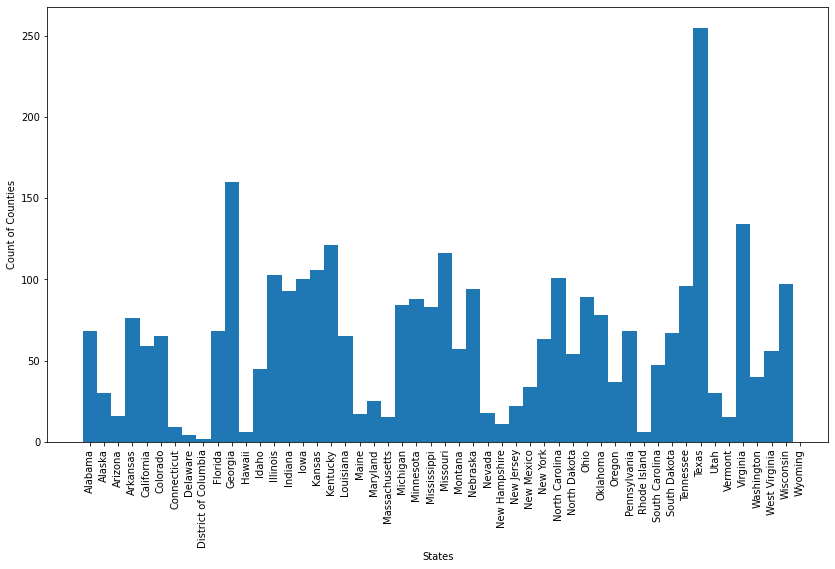

In [46]:
_ = plt.figure(figsize=(14,8))
_ = plt.hist(pop['STNAME'], bins=50, align='left')
_ = plt.xticks(rotation=90)
_ = plt.xlabel('States')
_ = plt.ylabel('Count of Counties')
plt.show()

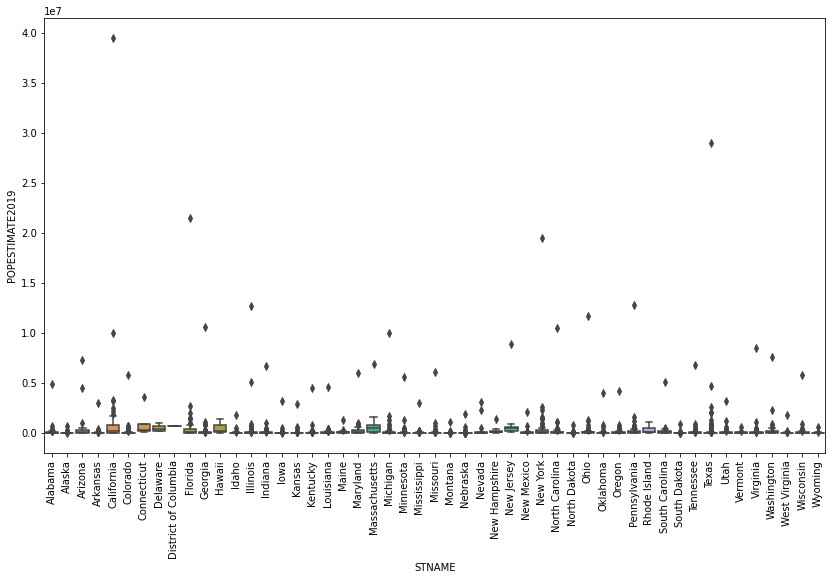

In [47]:
plt.figure(figsize=(14,8))
sns.boxplot(x=pop['STNAME'], y=pop['POPESTIMATE2019'], data=pop)
plt.xticks(rotation=90)
plt.show()

### 1.3.1 Import and Examine USA County Shapefile
Class Codes and Definitions For Reference<br>
https://www.census.gov/library/reference/code-lists/class-codes.html#:~:text=The%20class%20(CLASSFP)%20code%20defines,gazetteer%20files%2C%20and%20other%20products.

In [48]:
# Read_file method of importing data when it's saved to raw folder
# Refer to list of files in raw data directory listed in section 1.0.1
raw_path = '../data/raw/'

dbf = 'tl_2017_us_county.dbf'
prj = 'tl_2017_us_county.prj'
shp = 'tl_2017_us_county.shp'
shx = 'tl_2017_us_county.shx'

usa_counties = gpd.read_file(raw_path + shp)
print('Shape of dataframe: {}'.format(usa_counties.shape))
print('Projection of dataframe: {}'.format(usa_counties.crs))
usa_counties.tail()

Shape of dataframe: (3233, 18)
Projection of dataframe: epsg:4269


,STATEFP,COUNTYFP,COUNTYNS,GEOID,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,CSAFP,CBSAFP,METDIVFP,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
3228,13,123,00351260,13123,Gilmer,Gilmer County,06,H1,G4020,None,None,None,A,1103942496,12227724,+34.6905055,-084.4546244,"POLYGON ((-84.65478 34.66559, -84.65488 34.669..."
3229,27,135,00659513,27135,Roseau,Roseau County,06,H1,G4020,None,None,None,A,4329471930,16913419,+48.7610683,-095.8215042,"POLYGON ((-96.40466 48.80528, -96.40467 48.813..."
3230,28,089,00695768,28089,Madison,Madison County,06,H1,G4020,298,27140,None,A,1850209209,71667634,+32.6343703,-090.0341603,"POLYGON ((-90.09363 32.70763, -90.09360 32.707..."
3231,48,227,01383899,48227,Howard,Howard County,06,H1,G4020,None,13700,None,A,2333039139,8841781,+32.3034712,-101.4387720,"POLYGON ((-101.69227 32.27106, -101.69221 32.2..."
3232,54,099,01550056,54099,Wayne,Wayne County,06,H1,G4020,170,26580,None,A,1310504124,15860720,+38.1455413,-082.4196812,"POLYGON ((-82.59529 38.36978, -82.59515 38.369..."


In [49]:
# Examine information about dataframe
usa_counties.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 3233 entries, 0 to 3232
Data columns (total 18 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   STATEFP   3233 non-null   object  
 1   COUNTYFP  3233 non-null   object  
 2   COUNTYNS  3233 non-null   object  
 3   GEOID     3233 non-null   object  
 4   NAME      3233 non-null   object  
 5   NAMELSAD  3233 non-null   object  
 6   LSAD      3233 non-null   object  
 7   CLASSFP   3233 non-null   object  
 8   MTFCC     3233 non-null   object  
 9   CSAFP     1231 non-null   object  
 10  CBSAFP    1899 non-null   object  
 11  METDIVFP  113 non-null    object  
 12  FUNCSTAT  3233 non-null   object  
 13  ALAND     3233 non-null   int64   
 14  AWATER    3233 non-null   int64   
 15  INTPTLAT  3233 non-null   object  
 16  INTPTLON  3233 non-null   object  
 17  geometry  3233 non-null   geometry
dtypes: geometry(1), int64(2), object(15)
memory usage: 454.8+ KB


In [50]:
# Get summary statistics of objects
usa_counties.describe(include=[np.object]).T

,count,unique,top,freq
STATEFP,3233,56,48,254
COUNTYFP,3233,329,005,50
COUNTYNS,3233,3233,00974119,1
GEOID,3233,3233,28137,1
NAME,3233,1922,Washington,31
NAMELSAD,3233,1968,Washington County,30
LSAD,3233,11,06,3007
CLASSFP,3233,5,H1,3115
MTFCC,3233,1,G4020,3233
CSAFP,1231,174,490,48


### 1.3.2 Reduce Memory Usage of County Data
We notice there are quite a few columns that can be typecasted as category or numeric.

In [51]:
orig_mem = usa_counties.memory_usage(deep=True)
orig_mem

Index          128
STATEFP     190747
COUNTYFP    193980
COUNTYNS    210145
GEOID       200446
NAME        207450
NAMELSAD    230345
LSAD        190747
CLASSFP     190747
MTFCC       200446
CSAFP       121908
CBSAFP      149754
METDIVFP     81886
FUNCSTAT    213378
ALAND        25864
AWATER       25864
INTPTLAT    219844
INTPTLON    223077
geometry     25864
dtype: int64

In [52]:
# Change data type to categorical
usa_counties['STATEFP'] = usa_counties['STATEFP'].astype('category')
usa_counties['COUNTYFP'] = usa_counties['COUNTYFP'].astype('category')
usa_counties['LSAD'] = usa_counties['LSAD'].astype('category')
usa_counties['CLASSFP'] = usa_counties['CLASSFP'].astype('category')
usa_counties['MTFCC'] = usa_counties['MTFCC'].astype('category')
usa_counties['FUNCSTAT'] = usa_counties['FUNCSTAT'].astype('category')

# Change data type to numeric
usa_counties['COUNTYNS'] = pd.to_numeric(usa_counties['COUNTYNS'])
usa_counties['GEOID'] = pd.to_numeric(usa_counties['GEOID'])
usa_counties['CSAFP'] = pd.to_numeric(usa_counties['CSAFP'])
usa_counties['CBSAFP'] = pd.to_numeric(usa_counties['CBSAFP'])
usa_counties['METDIVFP'] = pd.to_numeric(usa_counties['METDIVFP'])

usa_counties.dtypes

STATEFP     category
COUNTYFP    category
COUNTYNS       int64
GEOID          int64
NAME          object
NAMELSAD      object
LSAD        category
CLASSFP     category
MTFCC       category
CSAFP        float64
CBSAFP       float64
METDIVFP     float64
FUNCSTAT    category
ALAND          int64
AWATER         int64
INTPTLAT      object
INTPTLON      object
geometry    geometry
dtype: object

In [53]:
new_mem = usa_counties.memory_usage(deep=True)
new_mem/orig_mem

Index       1.000000
STATEFP     0.047691
COUNTYFP    0.187885
COUNTYNS    0.123077
GEOID       0.129032
NAME        1.000000
NAMELSAD    1.000000
LSAD        0.022029
CLASSFP     0.019335
MTFCC       0.016837
CSAFP       0.212160
CBSAFP      0.172710
METDIVFP    0.315854
FUNCSTAT    0.018816
ALAND       1.000000
AWATER      1.000000
INTPTLAT    1.000000
INTPTLON    1.000000
geometry    1.000000
dtype: float64

### 1.3.3 Consolidate County Data
GeoDataFrame to include the 50 states and D.C.

In [54]:
# Check out FIPS Codes in dataset to see number of unique States
# https://www.nrcs.usda.gov/wps/portal/nrcs/detail/?cid=nrcs143_013696
usa_counties.STATEFP.nunique()

56

In [55]:
# 56 tells us that we are including more than just the 50 states
# We want a dataframe that is just the contiguous USA
# and one that includes the 50 states (plus DC)

# American Samoa (60), Guam (66), Northern Mariana Islands (69)
# Puerto Rico (72), Virgin Islands (78), Alaska (02), Hawaii (15)

# USA States
usa_state_counties = usa_counties[~usa_counties.STATEFP.isin(['60','66','69','72','78'])]
print(usa_state_counties.shape)

# Contiguous USA
usa_cont_counties = usa_state_counties[~usa_state_counties.STATEFP.isin(['02','15'])]
print(usa_cont_counties.shape)

(3142, 18)
(3108, 18)


In [56]:
# Compare to original
usa_counties.shape

(3233, 18)

### 1.4.1 Import and Examine USA State Shapefile

In [57]:
# Read_file method of importing data when it's saved to raw folder
# Source: https://www.census.gov/cgi-bin/geo/shapefiles/index.php?year=2019&layergroup=States+%28and+equivalent%29
# Refer to list of files in raw data directory listed in section 1.0.1
raw_path = '../data/raw/'

dbf = 'tl_2019_us_state.dbf'
prj = 'tl_2019_us_state.prj'
shp = 'tl_2019_us_state.shp'
shx = 'tl_2019_us_state.shx'

usa_states = gpd.read_file(raw_path + shp)
print('Shape of dataframe: {}'.format(usa_states.shape))
print('Projection of dataframe: {}'.format(usa_states.crs))
usa_states.tail()

Shape of dataframe: (56, 15)
Projection of dataframe: epsg:4269


,REGION,DIVISION,STATEFP,STATENS,GEOID,STUSPS,NAME,LSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
51,1,1,25,00606926,25,MA,Massachusetts,00,G4000,A,20204387828,7130663019,+42.1565196,-071.4895915,"POLYGON ((-71.49826 42.01727, -71.49907 42.017..."
52,3,5,51,01779803,51,VA,Virginia,00,G4000,A,102258306285,8527942672,+37.5222512,-078.6681938,"POLYGON ((-77.32832 39.05768, -77.32830 39.057..."
53,3,5,11,01702382,11,DC,District of Columbia,00,G4000,A,158340389,18687196,+38.9042474,-077.0165167,"POLYGON ((-77.11975 38.93435, -77.11886 38.935..."
54,2,4,19,01779785,19,IA,Iowa,00,G4000,A,144660467237,1084981626,+42.0700243,-093.4933473,"POLYGON ((-96.49878 42.56104, -96.48707 42.572..."
55,4,8,04,01779777,04,AZ,Arizona,00,G4000,A,294360282618,859561204,+34.2039355,-111.6063565,"POLYGON ((-114.51684 33.02789, -114.51699 33.0..."


In [58]:
usa_states.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 56 entries, 0 to 55
Data columns (total 15 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   REGION    56 non-null     object  
 1   DIVISION  56 non-null     object  
 2   STATEFP   56 non-null     object  
 3   STATENS   56 non-null     object  
 4   GEOID     56 non-null     object  
 5   STUSPS    56 non-null     object  
 6   NAME      56 non-null     object  
 7   LSAD      56 non-null     object  
 8   MTFCC     56 non-null     object  
 9   FUNCSTAT  56 non-null     object  
 10  ALAND     56 non-null     int64   
 11  AWATER    56 non-null     int64   
 12  INTPTLAT  56 non-null     object  
 13  INTPTLON  56 non-null     object  
 14  geometry  56 non-null     geometry
dtypes: geometry(1), int64(2), object(12)
memory usage: 6.7+ KB


In [59]:
# Review summary statistics for objects
usa_states.describe(include=[np.object]).T

,count,unique,top,freq
REGION,56,5,3,17
DIVISION,56,10,5,9
STATEFP,56,56,48,1
STATENS,56,56,01455989,1
GEOID,56,56,48,1
STUSPS,56,56,VA,1
NAME,56,56,District of Columbia,1
LSAD,56,1,00,56
MTFCC,56,1,G4000,56
FUNCSTAT,56,1,A,56


In [60]:
# Determine which columns to drop
usa_states.nunique()

REGION       5
DIVISION    10
STATEFP     56
STATENS     56
GEOID       56
STUSPS      56
NAME        56
LSAD         1
MTFCC        1
FUNCSTAT     1
ALAND       56
AWATER      56
INTPTLAT    56
INTPTLON    56
geometry    56
dtype: int64

In [61]:
# Drop columns with single value & duplicate columns
columns = ['LSAD','MTFCC','FUNCSTAT','GEOID']
usa_states.drop(columns, axis=1, inplace=True)
usa_states.head()

,REGION,DIVISION,STATEFP,STATENS,STUSPS,NAME,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,3,5,54,01779805,WV,West Virginia,62266231560,489271086,+38.6472854,-080.6183274,"POLYGON ((-81.74725 39.09538, -81.74635 39.096..."
1,3,5,12,00294478,FL,Florida,138947364717,31362872853,+28.4574302,-082.4091477,"MULTIPOLYGON (((-86.38865 30.99418, -86.38385 ..."
2,2,3,17,01779784,IL,Illinois,143779863817,6215723896,+40.1028754,-089.1526108,"POLYGON ((-91.18529 40.63780, -91.17510 40.643..."
3,2,4,27,00662849,MN,Minnesota,206230065476,18942261495,+46.3159573,-094.1996043,"POLYGON ((-96.78438 46.63050, -96.78434 46.630..."
4,3,5,24,01714934,MD,Maryland,25151726296,6979340970,+38.9466584,-076.6744939,"POLYGON ((-77.45881 39.22027, -77.45866 39.220..."


### 1.4.2 Reduce Memory Usage of State Data

In [62]:
usa_states.dtypes

REGION        object
DIVISION      object
STATEFP       object
STATENS       object
STUSPS        object
NAME          object
ALAND          int64
AWATER         int64
INTPTLAT      object
INTPTLON      object
geometry    geometry
dtype: object

In [63]:
# Convert to numeric
num_cols = ['REGION','DIVISION','STATEFP','STATENS','ALAND','AWATER']

for col in num_cols:
    usa_states[col] = pd.to_numeric(usa_states[col])

usa_states.dtypes

REGION         int64
DIVISION       int64
STATEFP        int64
STATENS        int64
STUSPS        object
NAME          object
ALAND          int64
AWATER         int64
INTPTLAT      object
INTPTLON      object
geometry    geometry
dtype: object

### 1.4.3 Consolidate State Data
GeoDataFrame to include the 50 states and D.C.

In [64]:
usa_states['STATEFP'].nunique()

56

In [65]:
# USA States
usa_states = usa_states[~usa_states.STATEFP.isin(['60','66','69','72','78'])]
print(usa_states.shape)

# Contiguous USA
usa_cont_states = usa_states[~usa_states.STATEFP.isin(['02','15'])]
print(usa_cont_states.shape)

(51, 11)
(49, 11)


### 1.5.1 Combine Visuals

In [71]:
gdf_hosp.head()

,County Name,Facility_Name,Full_Address,State,Total,latitudes,longitudes,STATEFP,COUNTYFP,geometry
0,HOUSTON,SOUTHEAST ALABAMA MEDICAL CENTER,"1108 ROSS CLARK CIRCLE,DOTHAN,HOUSTON,AL",AL,2427,31.215827,-85.363433,01,1069,POINT (-85.36343 31.21583)
1,MARSHALL,MARSHALL MEDICAL CENTERS,"2505 U S HIGHWAY 431 NORTH,BOAZ,MARSHALL,AL",AL,5104,34.601233,-87.123343,01,1095,POINT (-87.12334 34.60123)
2,LAUDERDALE,NORTH ALABAMA MEDICAL CENTER,"1701 VETERANS DRIVE,FLORENCE,LAUDERDALE,AL",AL,2120,34.805043,-87.650814,01,1077,POINT (-87.65081 34.80504)
3,JEFFERSON,ST. VINCENT'S EAST,"50 MEDICAL PARK EAST DRIVE,BIRMINGHAM,JEFFERSO...",AL,26142,33.564772,-86.760155,01,1073,POINT (-86.76016 33.56477)
4,SHELBY,SHELBY BAPTIST MEDICAL CENTER,"1000 FIRST STREET NORTH,ALABASTER,SHELBY,AL",AL,20720,33.075378,-86.519100,01,1117,POINT (-86.51910 33.07538)


(17.86546, 72.439786)

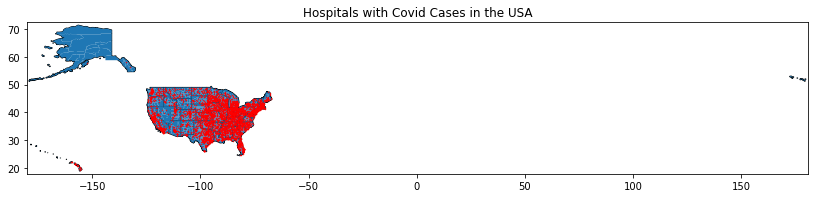

In [66]:
# Plot all counties with hospital data
fig, ax = plt.subplots(figsize=(14,12))
ax.set(title='Hospitals with Covid Cases in the USA')

# plot states
usa_states.plot(ax=ax, edgecolor='black', facecolor='none')
# plot counties
usa_state_counties.plot(ax=ax)
# plot hospitals
gdf_hosp.plot(markersize=0.2, color='red', ax=ax)

xlim = ([usa_states.total_bounds[0]-1,  usa_states.total_bounds[2]+1])
ylim = ([usa_states.total_bounds[1]-1,  usa_states.total_bounds[3]+1])

ax.set_xlim(xlim)
ax.set_ylim(ylim)

(23.396307999999998, 50.384479)

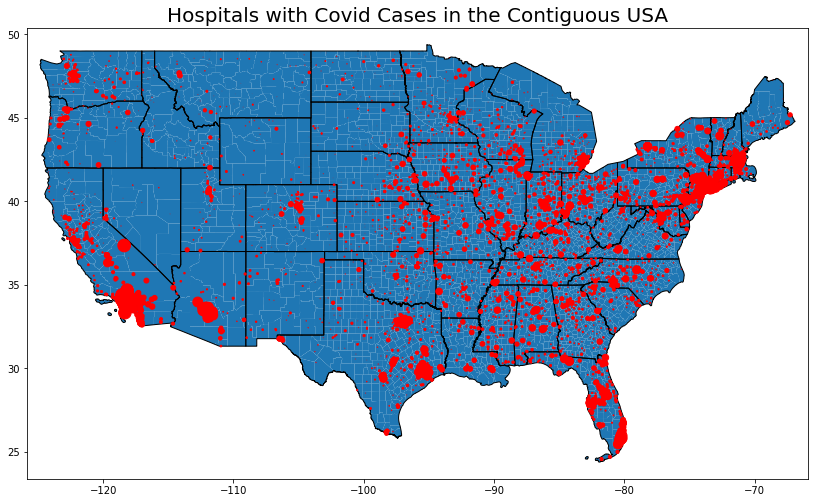

In [89]:
# Overlay maps to show hospitals with Covid cases in the contiguous USA

fig, ax = plt.subplots(figsize=(14,12))
ax.set_title('Hospitals with Covid Cases in the Contiguous USA',fontsize=20)

# Plot counties
usa_cont_counties.plot(ax=ax)
# Plot states
usa_cont_states.plot(ax=ax, edgecolor='black', facecolor='none')
# Plot hospitals
gdf_hosp.plot(markersize=gdf_hosp['Total']/1000, color='red', ax=ax)

# Limit to the contiguous USA
xlim = ([usa_cont_states.total_bounds[0]-1,  usa_cont_states.total_bounds[2]+1])
ylim = ([usa_cont_states.total_bounds[1]-1,  usa_cont_states.total_bounds[3]+1])

ax.set_xlim(xlim)
ax.set_ylim(ylim)

### 1.5.2 Relationship Between DataFrames

***Hospital Data and GeoData***
The <i>hosp</i> GeoDataFrame includes the total number of cases per hospital with Covid patients. Includes county name and state name.

***Population Data***
The <i>pop</i> dataframe includes state and county FP identifiers, along with county name and state name.

***County GeoData***
The <i>usa_state_counties</i> and <i>usa_cont_counties</i> GeoDataFrames include state FP, county FP, and county name. 

***State GeoData***
The <i>usa_states</i> and <i>usa_cont_states</i> GeoDataFrames include state FP and state name.

### 1.6.1 Save Datasets

In [90]:
'''# Save geodf of USA hospitals (hosp) --> ../data/interim
# 1_1_usa_hospitals_data.gpkg
gdf_hosp.to_file('../data/interim/1_1_usa_hospitals_data.gpkg', layer='hospitals', driver='GPKG')


# Save df of US Census by county (pop) --> ../data/interim
# 1_1_usa_population_county.csv
pop.to_csv('../data/interim/1_1_usa_population_county.csv')


# Save geodf of all USA state counties (usa_state_counties) --> ../data/interim
# 1_1_usa_counties_geo.gpkg
usa_state_counties.to_file('../data/interim/1_1_usa_counties_geo.gpkg', layer='USA counties', driver='GPKG')


# Save geodf of contiguous USA counties (usa_cont_counties) --> ../data/interim
# 1_1_usa_contiguous_counties_geo.shp
usa_cont_counties.to_file('../data/interim/1_1_usa_contiguous_counties_geo.gpkg', layer='USA counties contiguous', driver='GPKG')


# Save geodf of USA states (usa_states) --> ../data/interim
# 1_1_usa_state_borders_geo
usa_states.to_file('../data/interim/1_1_usa_state_borders_geo.gpkg')

# Save geodf of USA cont states (usa_cont_states)
# 1_1_usa_cont_state_borders_geo
usa_cont_states.to_file('../data/interim/1_1_usa_cont_state_borders_geo.gpkg')

# Using geopackage format due to faster rendering and contained in single file
'''

"# Save geodf of USA hospitals (hosp) --> ../data/interim\n# 1_1_usa_hospitals_data.gpkg\ngdf_hosp.to_file('../data/interim/1_1_usa_hospitals_data.gpkg', layer='hospitals', driver='GPKG')\n\n\n# Save df of US Census by county (pop) --> ../data/interim\n# 1_1_usa_population_county.csv\npop.to_csv('../data/interim/1_1_usa_population_county.csv')\n\n\n# Save geodf of all USA state counties (usa_state_counties) --> ../data/interim\n# 1_1_usa_counties_geo.gpkg\nusa_state_counties.to_file('../data/interim/1_1_usa_counties_geo.gpkg', layer='USA counties', driver='GPKG')\n\n\n# Save geodf of contiguous USA counties (usa_cont_counties) --> ../data/interim\n# 1_1_usa_contiguous_counties_geo.shp\nusa_cont_counties.to_file('../data/interim/1_1_usa_contiguous_counties_geo.gpkg', layer='USA counties contiguous', driver='GPKG')\n\n\n# Save geodf of USA states (usa_states) --> ../data/interim\n# 1_1_usa_state_borders_geo\nusa_states.to_file('../data/interim/1_1_usa_state_borders_geo.gpkg')\n\n# Save g